# DLAV Project - Phase 3

In this notebook we (Milica Vukasinovic, Antoine Dávid) will train a very simple planner and test its real-world performance.


The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

Now lets load the data and visualize how the real data looks like!

In [1]:
# initializing access to google drive
from google.colab import drive
import os
import zipfile

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

#paths to the data folders
val_path = '/content/drive/My Drive/val_real'
train_path = '/content/drive/My Drive/train'
test_path = '/content/drive/My Drive/test_public'

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
# Download the data to google drive (setup for colab)
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall("/content/drive/My Drive/")

download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = "dlav_val_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/")

download_url = "https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5"
output_zip = "test_public_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=87506bd8-9785-4a88-bae7-c5b2dcd64ae2
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:05<00:00, 77.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if
From (redirected): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if&confirm=t&uuid=6e3bb56b-ff90-4e9b-b2a8-a66ad3cb60a7
To: /content/dlav_val_real.zip
100%|██████████| 129M/129M [00:00<00:00, 173MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5
From (redirected): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5&confirm=t&uuid=12c68e94-d625-4346-a623-203e33a1121a
To: /content/test_public_real.zip
100%|██████████| 110M/110M [00:01<00:00, 65.7MB/s] 


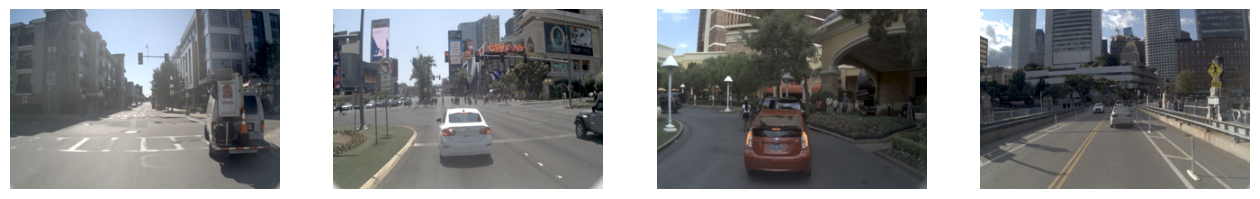

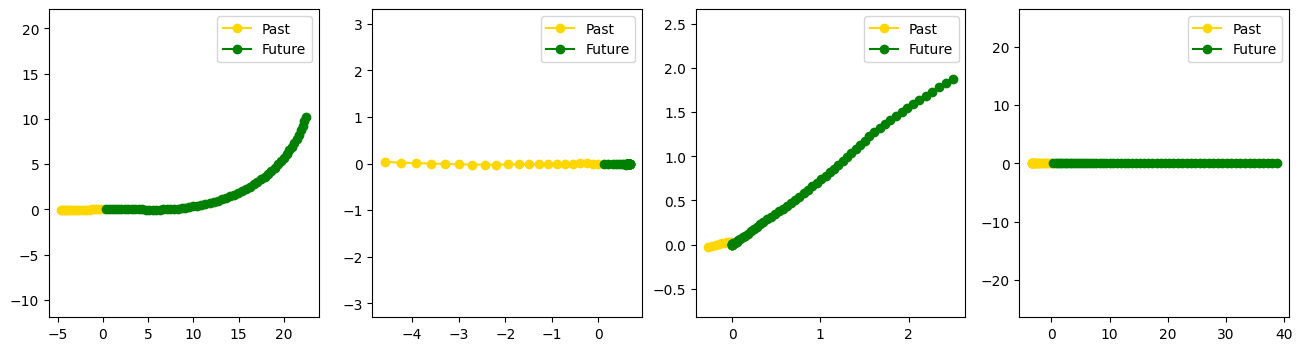

In [ ]:

import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import os
k = 4
# load the data
data = []
test_files = os.listdir(val_path)

for i in range(k):
    with open(val_path + f"/{test_files[i]}", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now let's train the model with synthetic data and test it with the real-world data.

In [2]:
import torch
from torch.utils.data import Dataset
import pickle
from torchvision.models.vision_transformer import ViT_B_32_Weights
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T

class DrivingDataset(Dataset):
    def __init__(self, file_list, augment = False, test=False):
        self.samples = file_list
        self.test = test

        # define data augmentation as a combination of changes
        self.augment = augment
        self.transform = T.Compose([
            T.ToPILImage(),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T.RandomHorizontalFlip(),
            T.RandomRotation(degrees=5),
            T.RandomResizedCrop((224, 224), scale=(0.9, 1.0), ratio=(1.0, 1.0)),  # Keep aspect ratio
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])
        self.transform_test = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((224, 224), ratio=(1.0, 1.0)),  # Keep aspect ratio
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])


    def __len__(self):
        return len(self.samples)

    def preprocess_camera(self, camera) -> torch.Tensor:
        """
        Args:
            camera_batch_np: numpy array of shape (B, 200, 300, 3) with RGB images
        Returns:
            torch.Tensor of shape (B, 3, 224, 224) ready for ViT
        """
        camera = camera.astype(np.uint8)
        if self.augment:
            camera = camera.astype(np.uint8)
            pil_image = self.transform(camera)
        else:
            pil_image = self.transform_test(camera)
        return pil_image

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = self.preprocess_camera(data['camera'])
        history = torch.FloatTensor(data['sdc_history_feature'])
        if not self.test:
          future = torch.FloatTensor(data['sdc_future_feature'])
          return {
            'camera': camera,
            'history': history,
            'future': future
          }
        else:
          return {
            'camera': camera,
            'history': history
          }



In [3]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

In [4]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from torchvision import transforms

class DrivingPlanner(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained ViT
        weights = ViT_B_16_Weights.DEFAULT
        self.vit = vit_b_16()

        # Freeze ViT (optional: set to False if you want to fine-tune)
        for param in self.vit.parameters():
            param.requires_grad = True

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )

        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.Linear(768 + 256, 512),  # 768 from ViT-B CLS token, 256 from history encoder
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 60 * 3)
        )

    def forward(self, camera, history):
        # Expecting camera input shape [B, 3, 224, 224] after preprocessing
        # If not already preprocessed, you can transform in the training loop like:
        # camera = torch.stack([self.transform(img) for img in camera])

        # Process image with ViT: output is [B, 1000] by default (classification logits)
        # But the feature before final head is at model.encoder.hidden_states[0]
        # We'll use the penultimate output (from forward_features)

        visual_features = self.vit._process_input(camera)
        n = visual_features.shape[0]
        # Expand the class token to the full batch
        batch_class_token = self.vit.class_token.expand(n, -1, -1)
        visual_features = torch.cat([batch_class_token, visual_features], dim=1)
        visual_features = self.vit.encoder(visual_features)
        cls_token = visual_features[:, 0]  # Take [CLS] token (shape [B, 768])

        # Process history
        history_flat = history.reshape(history.size(0), -1)
        history_features = self.history_encoder(history_flat)

        # Concatenate and decode
        combined = torch.cat([cls_token, history_features], dim=1)
        future = self.decoder(combined)
        return future.reshape(-1, 60, 3)


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
logger = Logger()

class TrajectoryLoss(nn.Module):
    '''
    the mse loss given in the template merely uses the positional training data for training.
    we propose a compined loss of that and the cosine of the difference in predicted heading.
    '''
    def __init__(self):
        super().__init__()
        self.position_loss = nn.MSELoss()
    def forward(self, pred, target):
        # pred/target shape: [B, 60, 3] (x,y,heading)
        pos_weight = 1.0
        heading_weight = 0.5  # Adjust based on importance
        # Position loss (x,y)
        pos_loss = self.position_loss(pred[..., :2], target[..., :2])
        # heading loss
        heading_diff = pred[..., 2] - target[..., 2]
        heading_loss = 1 - torch.cos(heading_diff).mean()
        return pos_weight * pos_loss + heading_weight * heading_loss
criterion = TrajectoryLoss()

def train_one_epoch(model, train_loader, optimizer, device, epoch = 0):
    # runs one epoch
    model.train()
    train_loss = 0
    for idx, batch in enumerate(train_loader):
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        future = batch['future'].to(device)

        optimizer.zero_grad()
        pred_future = model(camera, history)
        loss = criterion(pred_future, future)
        loss.backward()
        optimizer.step()

        if idx % 10 == 0:
            logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
        train_loss += loss.item()
    return train_loss

def validate(model, val_loader, device):
    # Validation
    model.eval()
    val_loss, ade_all, fde_all = 0, [], []
    with torch.no_grad():
        for batch in val_loader:
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)

            pred_future = model(camera, history)
            loss = criterion(pred_future, future)
            ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
            FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
            ade_all.append(ADE.item())
            fde_all.append(FDE.item())
            val_loss += loss.item()
    ADE = np.mean(ade_all)
    FDE = np.mean(fde_all)
    return ADE,FDE,val_loss

def train(model, optimizer, num_epochs=70, train_files = [], val_loader=[], scheduler = None):
    # main training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    ADE, FDE, val_loss = validate(model, val_loader, device)
    print(f'starting with Val Loss: {val_loss/len(val_loader):.4f} | ADE: {ADE:.4f} | FDE: {FDE:.4f}')
    best_ade = ADE

    for epoch in range(num_epochs):
        train_dataset = DrivingDataset(train_files, augment = True)
        train_loader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True)

        for sub_epoch in range(1):
            train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
            ADE, FDE, val_loss = validate(model, val_loader, device)
            print(f'Epoch {sub_epoch+1}/{1} in {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | ADE: {ADE:.4f} | FDE: {FDE:.4f}')
            scheduler.step(val_loss/len(val_loader))
            # save the best model (distinguished by ADE score)
            if ADE < best_ade:
                best_ade = ADE
                torch.save(model.state_dict(), "/content/drive/My Drive/best_model.pth")
                print(f"Model saved at epoch {epoch+1} with ADE: {best_ade:.4f}")



In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os
usePretrained = True

train_data_dir = train_path
real_data_dir = val_path
train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]
val_dataset = DrivingDataset(test_files)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2)

criterion = TrajectoryLoss()
model = DrivingPlanner()
if usePretrained:
    model.load_state_dict(torch.load("/content/drive/My Drive/best_model.pth"))

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)
logger = Logger()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


train(model, optimizer, num_epochs=20, train_files=train_files, val_loader=val_loader, scheduler=scheduler)


Using device: cuda
starting with Val Loss: 5.7798 | ADE: 1.8972 | FDE: 5.3722
Epoch 1/1 in 1/20 | Train Loss: 5.6525 | Val Loss: 6.3371 | ADE: 1.9621 | FDE: 5.5992
Epoch 1/1 in 2/20 | Train Loss: 5.8333 | Val Loss: 5.8757 | ADE: 1.8334 | FDE: 5.2564
Model saved at epoch 2 with ADE: 1.8334
Epoch 1/1 in 3/20 | Train Loss: 5.6190 | Val Loss: 6.0358 | ADE: 1.8535 | FDE: 5.3023
Epoch 1/1 in 4/20 | Train Loss: 5.6498 | Val Loss: 6.3838 | ADE: 1.9748 | FDE: 5.5572
Epoch 1/1 in 5/20 | Train Loss: 5.6955 | Val Loss: 6.0552 | ADE: 1.9365 | FDE: 5.4226
Epoch 1/1 in 6/20 | Train Loss: 5.4214 | Val Loss: 6.2703 | ADE: 1.9411 | FDE: 5.4500
Epoch 1/1 in 7/20 | Train Loss: 5.2140 | Val Loss: 6.1610 | ADE: 1.8647 | FDE: 5.4083
Epoch 1/1 in 8/20 | Train Loss: 5.0996 | Val Loss: 5.9532 | ADE: 1.8290 | FDE: 5.3157
Model saved at epoch 8 with ADE: 1.8290
Epoch 1/1 in 9/20 | Train Loss: 5.1444 | Val Loss: 6.2241 | ADE: 1.8857 | FDE: 5.4837
Epoch 1/1 in 10/20 | Train Loss: 5.0497 | Val Loss: 5.9766 | ADE: 1.

We see a hugh sim-to-real gap here! Although the planner works well with synthetic sensors, it cannot generalize to the real wolrd scenario.

How to generalize your planner to the real world? Let's expore a simple trick: data mixing. This time we mix part of the real data with the synthetic data to train the model.

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = train_path
real_data_dir = val_path
train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]
val_dataset = DrivingDataset(test_files)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2)

criterion = TrajectoryLoss()
model = DrivingPlanner()
model.load_state_dict(torch.load("/content/drive/My Drive/best_model.pth"))

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)
logger = Logger()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


train(model, optimizer, num_epochs=20, train_files=train_files, val_loader=val_loader, scheduler=scheduler)


Using device: cuda
starting with Val Loss: 5.3583 | ADE: 1.7260 | FDE: 5.0193
Epoch 1/1 in 1/30 | Train Loss: 5.4337 | Val Loss: 5.4776 | ADE: 1.7685 | FDE: 5.0753
Epoch 1/1 in 2/30 | Train Loss: 5.3176 | Val Loss: 5.4214 | ADE: 1.7317 | FDE: 5.0475
Epoch 1/1 in 3/30 | Train Loss: 5.2869 | Val Loss: 5.7376 | ADE: 1.8906 | FDE: 5.4290
Epoch 1/1 in 4/30 | Train Loss: 5.2543 | Val Loss: 5.6355 | ADE: 1.8577 | FDE: 5.1625
Epoch 1/1 in 5/30 | Train Loss: 5.3288 | Val Loss: 5.3460 | ADE: 1.7117 | FDE: 4.9431
Model saved at epoch 5 with ADE: 1.7117
Epoch 1/1 in 6/30 | Train Loss: 5.1738 | Val Loss: 5.3678 | ADE: 1.7926 | FDE: 5.1719
Epoch 1/1 in 7/30 | Train Loss: 5.2224 | Val Loss: 5.5834 | ADE: 1.8540 | FDE: 5.3543
Epoch 1/1 in 8/30 | Train Loss: 5.1696 | Val Loss: 5.3398 | ADE: 1.7049 | FDE: 4.8901
Model saved at epoch 8 with ADE: 1.7049
Epoch 1/1 in 9/30 | Train Loss: 5.1596 | Val Loss: 5.6124 | ADE: 1.7594 | FDE: 5.0550
Epoch 1/1 in 10/30 | Train Loss: 5.2562 | Val Loss: 5.4995 | ADE: 1.

Finally, generate your submission.

In [11]:
import pandas as pd
from torch.utils.data import DataLoader
test_data_dir = test_path + '_real'
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)

model = DrivingPlanner()
model.load_state_dict(torch.load("/content/drive/My Drive/best_model.pth"))
model = model.to(device)
model.eval()
all_plans = []
device = 'cuda'
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase3.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (864, 121)
